# Pengerjaan Tugas Deep Learning menggunakan TensorFlow (Week 7, Dataset DeteksiSarkasme)

File ini memuat pelatihan model Bidirectional RNN dan Deep RNN, masing-masing menggunakan TensorFlow, untuk dataset DeteksiSarkasme.json

# Persiapan: Instalasi library dan Data Preprocessing

### 1. Memastikan Instalasi library

In [1]:
# !pip install numpy matplotlib scikit-learn torch tensorflow
# %pip install numpy matplotlib scikit-learn torch tensorflow[and-cuda] keras-tuner nltk

### 2. Mengimpor Library yang Dibutuhkan

In [2]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras_tuner as kt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import json
import re
import string
import time
from copy import deepcopy

# Memeriksa apakah GPU tersedia dan dapat digunakan oleh TensorFlow
gpu_available = tf.test.is_gpu_available()
print(f"GPU available: {gpu_available}")


2025-04-25 00:24:36.114406: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 00:24:36.191610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745515476.221934  144036 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745515476.230494  144036 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745515476.297478  144036 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available: True


I0000 00:00:1745515480.251229  144036 gpu_device.cc:2019] Created device /device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


### 3. Mendefinisikan Parameter dan Pre-processing Dataset

In [ ]:
# Konstanta dan parameter
NUM_WORDS = 40000
MAXLEN = 30
BATCH_SIZE = 16
EPOCHS = 25

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
# Inisialisasi lemmatizer
lemmatizer = WordNetLemmatizer()
# Inisialisasi stopwords
stop_words = set(stopwords.words('english'))

# Baca file JSON yang tidak terformat
input_file = "../DeteksiSarkasme.json"
json_data = []

with open(input_file, "r") as file:
    data = file.read()

# Tampilkan cuplikan dari data JSON yang tidak terformat
print("Cuplikan data JSON yang tidak terformat:")
print(data[:500])  # Menampilkan 500 karakter pertama untuk cuplikan

# Tambahkan koma di antara objek JSON
formatted_data = "[" + data.replace("}\n{", "},\n{") + "]"

# Tampilkan cuplikan dari data JSON yang sudah diformat
print("\nCuplikan data JSON yang sudah diformat:")
print(formatted_data[:500])  # Menampilkan 500 karakter pertama untuk cuplikan

# Parse ulang untuk memastikan validitas JSON
try:
    json_data = json.loads(formatted_data)
    print("\nData JSON berhasil diformat.")

except json.JSONDecodeError as e:
    print(f"Terjadi kesalahan saat memformat JSON: {e}")

# Inisialisasi DataFrame dari data JSON
df = pd.DataFrame(json_data)

# Memeriksa distribusi kelas
print("Class distribution:")
print(df['is_sarcastic'].value_counts())
print("\nPercentage:")
print(df['is_sarcastic'].value_counts(normalize=True) * 100)

# Fungsi Text preprocessing
def preprocess_text(text):
    # Membuat teks menjadi huruf kecil
    text = text.lower()
    
    # Pertahankan tanda baca yang berpotensi penting untuk sarkasme
    text = re.sub(r'[^\w\s\'\"!?.,]', '', text)
    
    # Tokenisasi
    tokens = word_tokenize(text)
    
    # Filter stopwords secara selektif (pertahankan kata-kata penting)
    custom_stopwords = set(stopwords.words('english')) - {'not', 'no', 'very', 'too', 'only', 'just'}
    tokens = [word for word in tokens if word not in custom_stopwords]

    return ' '.join(tokens)

# Menerapkan preprocessing ke headlines
df['processed_headline'] = df['headline'].apply(preprocess_text)
print("\nProcessed headlines:")
print(df['processed_headline'].head())

# Mengambil kata tambahan dari link artikel
df['additional_words'] = df['article_link'].apply(
    lambda x: re.findall(r'\w+', x.split('/')[-1]) if '/' in x else []
).apply(lambda x: [word for word in x if word not in ['html', 'htm'] and len(word) > 1])
df['additional_words'] = df['additional_words'].apply(
    lambda x: x[:-1] + x[-1].split('_')[:-1] if x and len(x[-1].split('_')) > 1 else x
)
df['additional_words'] = df['additional_words'].apply(
    lambda x: x[:-1] if x and len(x[-1]) < 3 else x
)
print(df['additional_words'])

# Menggabungkan headline dan kata tambahan 
df['processed_headline'] = ' ' + df['additional_words'].apply(' '.join) + ' ' + df['processed_headline']
print("\nCombined processed headlines:")
print(df['processed_headline'].head())

# Memeriksa adanya null values
print("\nChecking for null values:")
print(df.isnull().sum())

# Menghilangkan baris dengan null values
df.dropna(inplace=True)
print("\nAfter dropping null values:")
print(df.isnull().sum())

# Split data
X = df['processed_headline'].values
y = df['is_sarcastic'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# Tokenisasi dan padding untuk model deep learning
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Mendapatkan ukuran vocabulary
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# Padding sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAXLEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAXLEN, padding='post')

# Untuk TensorFlow
train_data = (X_train_pad, y_train)
test_data = (X_test_pad, y_test)

[nltk_data] Downloading package punkt to /home/husain/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/husain/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/husain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/husain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cuplikan data JSON yang tidak terformat:
{"article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5", "headline": "former versace store clerk sues over secret 'black code' for minority shoppers", "is_sarcastic": 0}
{"article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365", "headline": "the 'roseanne' revival catches up to our thorny political mood, for better and worse", "is_sarcastic": 0}
{"article_link": "https://local.theonion.com/mom-starti

Cuplikan data JSON yang sudah diformat:
[{"article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5", "headline": "former versace store clerk sues over secret 'black code' for minority shoppers", "is_sarcastic": 0},
{"article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365", "headline": "the 'roseanne' revival catches up to our thorny political mood, for better a

### 4. Menyiapkan Fungsi Pelatihan Model

In [4]:
# Fungsi untuk melatih model TensorFlow
def train_model_tf(model, train_data, model_name):
    x_train, y_train = train_data
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            filepath=f'model_tensorflow_{model_name}.keras',
            monitor='val_loss',
            save_best_only=True
        )
    ]
    
    print(f"Memulai pelatihan model {model_name}...")
    start_time = time.time()
    
    # Melatih model
    history = model.fit(
        x_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        shuffle=True,
        callbacks=callbacks,
        verbose=1
    )
    
    end_time = time.time()
    training_time = end_time - start_time
    mins, secs = divmod(training_time, 60)
    print(f"Waktu pelatihan: {int(mins)}m {int(secs)}s")
    
    return history

### 5. Menyiapkan Fungsi Evaluasi

In [5]:
# Fungsi untuk evaluasi model TensorFlow
def evaluate_model_tf(model, test_data, model_name):
    x_test, y_test = test_data
    
    # Prediksi
    y_pred_prob = model.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    # Menghitung ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    
    # Print hasil evaluasi
    print(f"\nEvaluasi Model {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred_prob': y_pred_prob,
        'y_pred': y_pred,
        'y_test': y_test
    }

### 6. Menyiapkan Fungsi Visualisasi

In [6]:
# Fungsi untuk membuat visualisasi hasil
# Fungsi untuk membuat visualisasi training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))
    
    best_epoch = history['val_loss'].index(min(history['val_loss']))
    best_val_loss = min(history['val_loss'])

    # Plot Loss, dengan tanda pada titik terbaik
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Valid Loss')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
    plt.axhline(y=best_val_loss, color='g', linestyle='--', label='Best Val Loss')
    plt.title(f'{model_name} - Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Valid Accuracy')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
    plt.axhline(y=history['val_accuracy'][best_epoch], color='g', linestyle='--', label='Val Accuracy at Best Model')
    plt.title(f'{model_name} - Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'training_history_tensorflow_{model_name}.png')
    plt.show()

# Fungsi untuk membuat confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])
    
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_tensorflow_{model_name}.png')
    plt.show()

# Fungsi untuk membuat ROC curve
def plot_roc_curve(results_dict):
    plt.figure(figsize=(10, 8))
    
    for model_name, result in results_dict.items():
        plt.plot(result['fpr'], result['tpr'], label=f'{model_name} (AUC = {result["auc"]:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.grid(True)
    plt.savefig('roc_curve_comparison_tensorflow.png')
    plt.show()

# Fungsi untuk membuat bar chart perbandingan metrik
def plot_metrics_comparison(results_dict):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    models = list(results_dict.keys())
    
    values = {metric: [results_dict[model][metric] for model in models] for metric in metrics}
    
    plt.figure(figsize=(12, 8))
    bar_width = 0.15
    index = np.arange(len(models))
    
    for i, metric in enumerate(metrics):
        plt.bar(index + i * bar_width, values[metric], bar_width, 
                label=metric.capitalize())
    
    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title('Performance Metrics Comparison')
    plt.xticks(index + bar_width * 2, models)
    plt.legend()
    plt.grid(True, axis='y')
    plt.savefig('metrics_comparison_tensorflow.png')
    plt.show()


## A. Model Bidirectional RNN Menggunakan TensorFlow

### 1. Menyusun Model Bidirectional RNN


In [7]:
# Fungsi untuk membuat model RNN bidireksional kompleks dengan LSTM
def build_birnn_model(embedding_dim=128, lstm_units=64, dropout_rate=0.2, recurrent_dropout=0.2, dense_units=32, learning_rate=0.001):
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, embedding_dim),
        
        Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=dropout_rate)),
        BatchNormalization(),
        Bidirectional(LSTM(lstm_units, return_sequences=False, dropout=dropout_rate)),
        BatchNormalization(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    
    # Menyusun model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Menampilkan ringkasan model
    print(model.summary())

    return model

# inisialisasi model
model_birnn = build_birnn_model()

I0000 00:00:1745515482.825996  144036 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 30, 128)        │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,322,817 (20.30 MB)

 Trainable params: 5,322,305 (20.30 MB)

 Non-trainable params: 512 (2.00 KB)

None


### 2. Melatih Model dan Hyperparameter Tuning

In [8]:
# Melatih model RNN awal
print("Melatih model RNN...")
history_birnn = train_model_tf(model_birnn, (X_train_pad, y_train), 'birnn')

# Menggunakan hyperparameter tuning untuk mengoptimalkan model
# Fungsi untuk membuat model dengan hyperparameter tuning
def build_hptune_birnn_model(hp):
    # Hyperparameter yang akan dituning   
    embedding_dim = hp.Int('embedding_dim', min_value=64, max_value=256, step=32)
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    recurrent_dropout = hp.Float('recurrent_dropout', min_value=0.0, max_value=0.3, step=0.1)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    
    model = build_birnn_model(
        embedding_dim=embedding_dim,
        lstm_units=lstm_units,
        dropout_rate=dropout_rate,
        recurrent_dropout=recurrent_dropout,
        dense_units=dense_units,
        learning_rate=learning_rate
    )
    
    return model

# Inisialisasi hyperparameter tuner
tuner_birnn = kt.Hyperband(
    build_hptune_birnn_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='tuning_results',
    project_name='tuning_birnn',
)

# Menjalankan hyperparameter tuning
tuner_birnn.search(X_train_pad, y_train, epochs=3, batch_size=BATCH_SIZE, validation_split=0.2,
             shuffle=True,
             callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
             verbose=1
)

# Menampilkan hasil hyperparameter tuning
best_hps_birnn = tuner_birnn.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters:")
print(f"Embedding dimension: {best_hps_birnn.get('embedding_dim')}")
print(f"LSTM units: {best_hps_birnn.get('lstm_units')}")
print(f"Dropout rate: {best_hps_birnn.get('dropout_rate')}")
print(f"Recurrent dropout rate: {best_hps_birnn.get('recurrent_dropout')}")
print(f"Learning rate: {best_hps_birnn.get('learning_rate')}")
print(f"Dense units: {best_hps_birnn.get('dense_units')}")

# Membangun model dengan hyperparameter terbaik
model_birnn = tuner_birnn.hypermodel.build(best_hps_birnn)

# Melatih model dengan hyperparameter terbaik
print("Melatih model dengan hyperparameter terbaik...")
history_birnn = train_model_tf(model_birnn, (X_train_pad, y_train), 'birnn')

Trial 10 Complete [00h 03m 29s]
val_accuracy: 0.8949461579322815

Best val_accuracy So Far: 0.8949461579322815
Total elapsed time: 00h 24m 27s
Best Hyperparameters:
Embedding dimension: 192
LSTM units: 32
Dropout rate: 0.2
Recurrent dropout rate: 0.0
Learning rate: 0.0030995872235361046
Dense units: 32


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 30, 192)        │     7,680,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 30, 64)         │        57,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,765,057 (29.62 MB)

 Trainable params: 7,764,801 (29.62 MB)

 Non-trainable params: 256 (1.00 KB)

None
Melatih model dengan hyperparameter terbaik...
Memulai pelatihan model birnn...
Epoch 1/25
 222/1069 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.7015 - loss: 0.6006

1069/1069 ━━━━━━━━━━━━━━━━━━━━ 58s 52ms/step - accuracy: 0.7876 - loss: 0.4628 - val_accuracy: 0.8865 - val_loss: 0.2896
Epoch 2/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.9522 - loss: 0.1333 - val_accuracy: 0.8781 - val_loss: 0.3245
Epoch 3/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 52s 48ms/step - accuracy: 0.9873 - loss: 0.0428 - val_accuracy: 0.8767 - val_loss: 0.4273
Epoch 4/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 50s 46ms/step - accuracy: 0.9876 - loss: 0.0374 - val_accuracy: 0.8753 - val_loss: 0.6063
Epoch 5/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 53s 50ms/step - accuracy: 0.9935 - loss: 0.0225 - val_accuracy: 0.8769 - val_loss: 0.7895
Epoch 6/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 51s 48ms/step - accuracy: 0.9945 - loss: 0.0172 - val_accuracy: 0.8741 - val_loss: 0.6610
Waktu pelatihan: 5m 10s


### 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [9]:
# Evaluasi model RNN
result_birnn = evaluate_model_tf(model_birnn, test_data, 'birnn')

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

Evaluasi Model birnn:
Accuracy: 0.8819
Precision: 0.8688
Recall: 0.8610
F1 Score: 0.8649
AUC: 0.9508


### 4. Memvisualisasikan Prediksi dari model yang telah dilatih

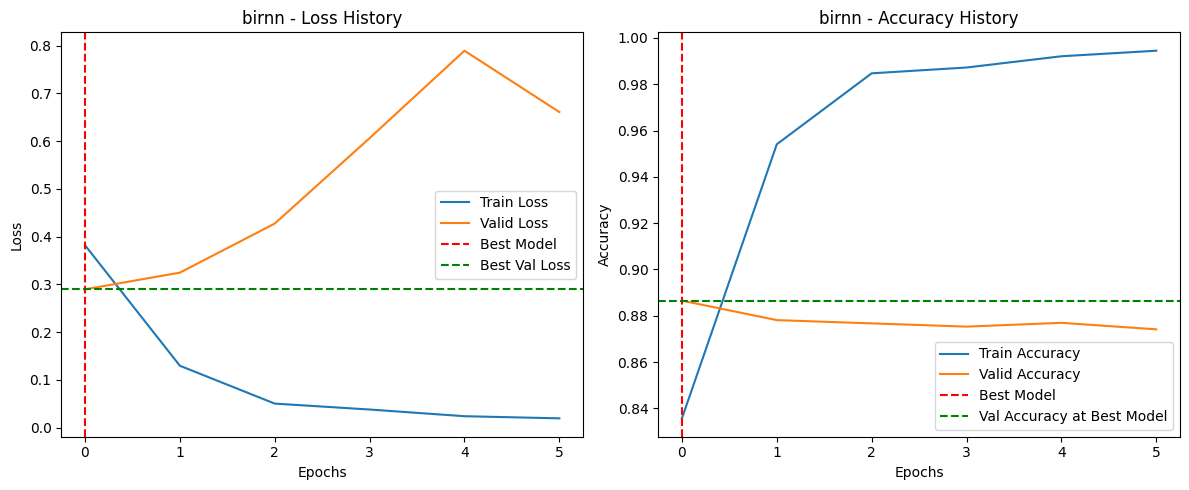

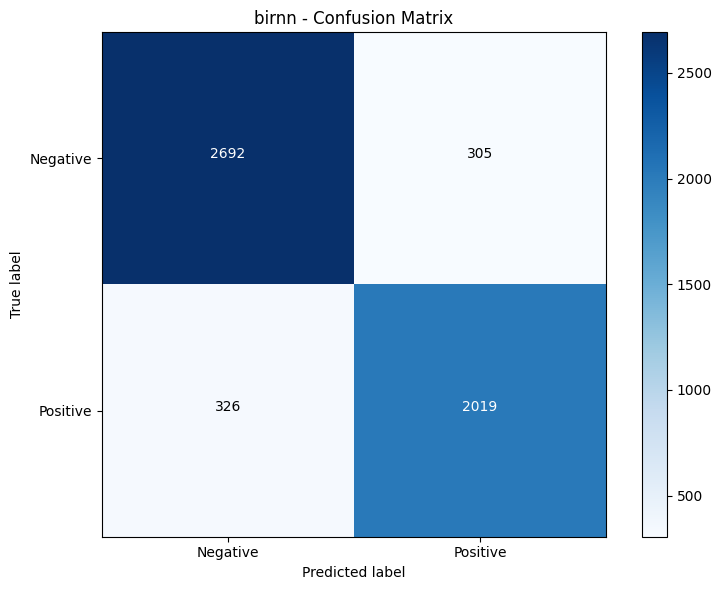

In [10]:
# Plotting hasil pelatihan
plot_training_history(history_birnn.history, "birnn")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_birnn['y_pred'], "birnn")

### 5. Menyimpan Model

In [11]:
# Menyimpan model
model_birnn.save('model_tensorflow_birnn.keras')
print("Model RNN disimpan sebagai 'model_tensorflow_birnn.keras'")

Model RNN disimpan sebagai 'model_tensorflow_birnn.keras'


## B. Model Deep RNN Menggunakan TensorFlow

### 1. Menyusun Model Deep RNN


In [12]:
# Fungsi untuk membuat model Deep RNN kompleks dengan LSTM
def build_drnn_model(embedding_dim=128, lstm_units=64, dropout_rate=0.2, recurrent_dropout=0.2, dense_units=64, learning_rate=0.001):
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, embedding_dim),
        
        LSTM(lstm_units, return_sequences=True, dropout=dropout_rate),
        BatchNormalization(),
        LSTM(lstm_units, return_sequences=True, dropout=dropout_rate),
        BatchNormalization(),
        LSTM(lstm_units, return_sequences=True, dropout=dropout_rate),
        BatchNormalization(),
        LSTM(lstm_units, return_sequences=True, dropout=dropout_rate),
        BatchNormalization(),
        LSTM(lstm_units, return_sequences=False, dropout=dropout_rate),
        BatchNormalization(),
        
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(dense_units // 2, activation='relu'),
        Dropout(dropout_rate),
        Dense(dense_units // 4, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    # Menyusun model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# inisialisasi model
model_drnn = build_birnn_model()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 30, 128)        │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,322,817 (20.30 MB)

 Trainable params: 5,322,305 (20.30 MB)

 Non-trainable params: 512 (2.00 KB)

None


### 2. Melatih Model

In [13]:
# Melatih model RNN awal
print("Melatih model RNN...")
history_drnn = train_model_tf(model_drnn, (X_train_pad, y_train), 'birnn')

# Fungsi untuk membuat model dengan hyperparameter tuning
def build_hptune_drnn_model(hp):
    # Hyperparameters to tune
    embedding_dim = hp.Int('embedding_dim', min_value=64, max_value=256, step=32)
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    recurrent_dropout = hp.Float('recurrent_dropout', min_value=0.0, max_value=0.3, step=0.1)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    
    model = build_drnn_model(
        embedding_dim=embedding_dim,
        lstm_units=lstm_units,
        dropout_rate=dropout_rate,
        recurrent_dropout=recurrent_dropout,
        dense_units=dense_units,
        learning_rate=learning_rate
    )
    
    return model

# Inisialisasi hyperparameter tuner
tuner_drnn = kt.Hyperband(
    build_hptune_drnn_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='tuning_results',
    project_name='tuning_drnn'
)

# Menjalankan hyperparameter tuning
tuner_drnn.search(X_train_pad, y_train, epochs=3, batch_size=BATCH_SIZE, validation_split=0.2,
             shuffle=True,
             callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
             verbose=1
)

# Menampilkan hasil hyperparameter tuning
best_hps_drnn = tuner_drnn.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters:")
print(f"Embedding dimension: {best_hps_drnn.get('embedding_dim')}")
print(f"LSTM units: {best_hps_drnn.get('lstm_units')}")
print(f"Dropout rate: {best_hps_drnn.get('dropout_rate')}")
print(f"Recurrent dropout rate: {best_hps_drnn.get('recurrent_dropout')}")
print(f"Learning rate: {best_hps_drnn.get('learning_rate')}")
print(f"Dense units: {best_hps_drnn.get('dense_units')}")

# Membangun model dengan hyperparameter terbaik
model_drnn = tuner_drnn.hypermodel.build(best_hps_drnn)

# Melatih model dengan hyperparameter terbaik
print("Melatih model dengan hyperparameter terbaik...")
history_drnn = train_model_tf(model_drnn, (X_train_pad, y_train), 'birnn')

Trial 10 Complete [00h 05m 25s]
val_accuracy: 0.8518951535224915

Best val_accuracy So Far: 0.8752924799919128
Total elapsed time: 00h 33m 41s
Best Hyperparameters:
Embedding dimension: 160
LSTM units: 32
Dropout rate: 0.2
Recurrent dropout rate: 0.2
Learning rate: 0.00048372585966754625
Dense units: 64
Melatih model dengan hyperparameter terbaik...
Memulai pelatihan model birnn...
Epoch 1/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 63s 55ms/step - accuracy: 0.5993 - loss: 0.6538 - val_accuracy: 0.8341 - val_loss: 0.3997
Epoch 2/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 62s 58ms/step - accuracy: 0.8703 - loss: 0.3488 - val_accuracy: 0.8758 - val_loss: 0.3239
Epoch 3/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 62s 58ms/step - accuracy: 0.9386 - loss: 0.1950 - val_accuracy: 0.8711 - val_loss: 0.3293
Epoch 4/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 60s 56ms/step - accuracy: 0.9673 - loss: 0.1186 - val_accuracy: 0.8655 - val_loss: 0.4587
Epoch 5/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 61s 57ms/step - accuracy: 0.9841 - loss: 0.05

### 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [14]:
# Evaluasi model RNN
result_drnn = evaluate_model_tf(model_drnn, test_data, 'drnn')

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

Evaluasi Model drnn:
Accuracy: 0.8815
Precision: 0.8466
Recall: 0.8917
F1 Score: 0.8685
AUC: 0.9498


### 4. Memvisualisasikan Prediksi dari model yang telah dilatih

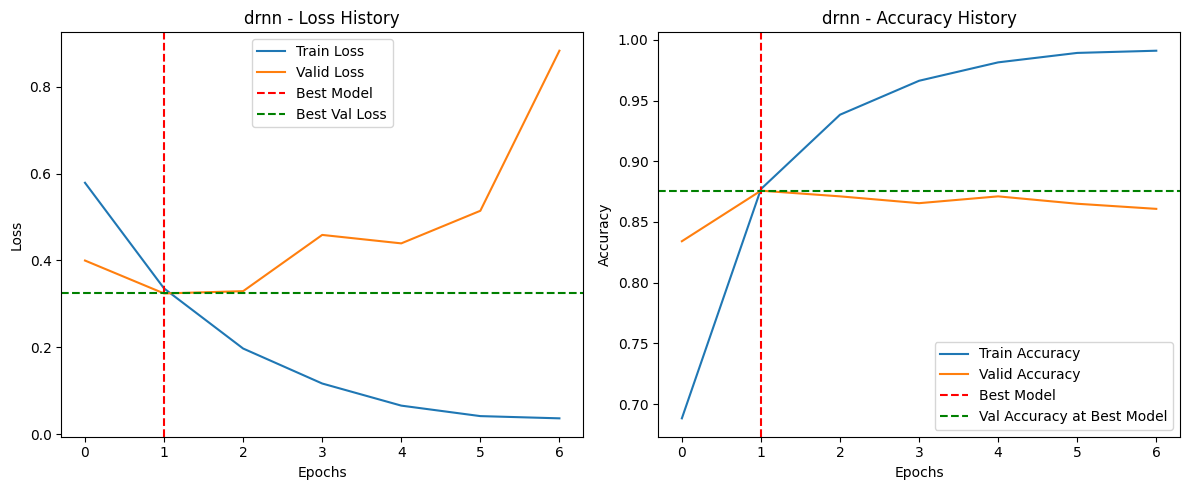

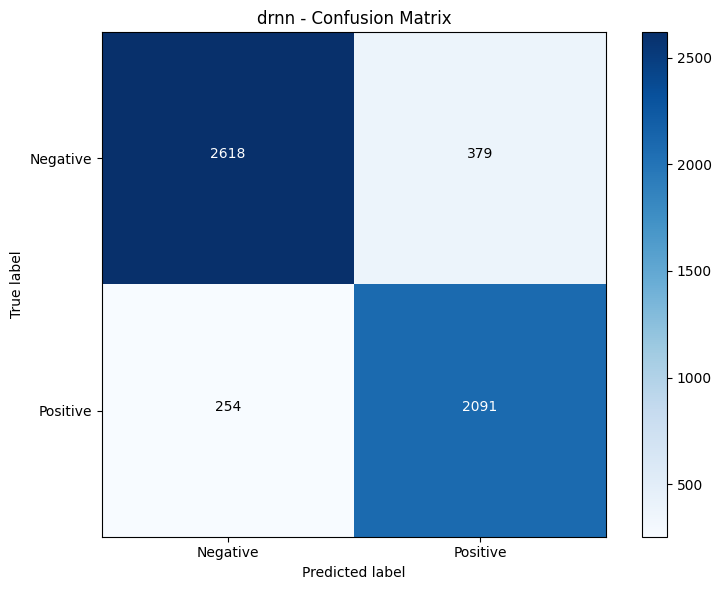

In [15]:
# Plotting hasil pelatihan
plot_training_history(history_drnn.history, "drnn")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_drnn['y_pred'], "drnn")

### 5. Menyimpan Model

In [16]:
# Menyimpan model
model_birnn.save('model_tensorflow_drnn.keras')
print("Model RNN disimpan sebagai 'model_tensorflow_drnn.keras'")

Model RNN disimpan sebagai 'model_tensorflow_drnn.keras'


# Perbandingan antara model

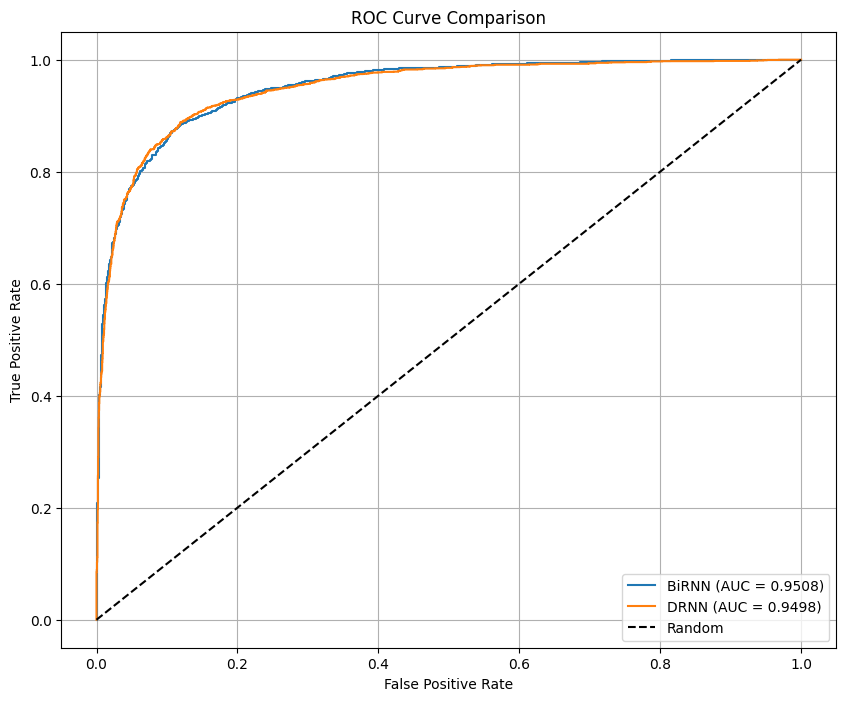

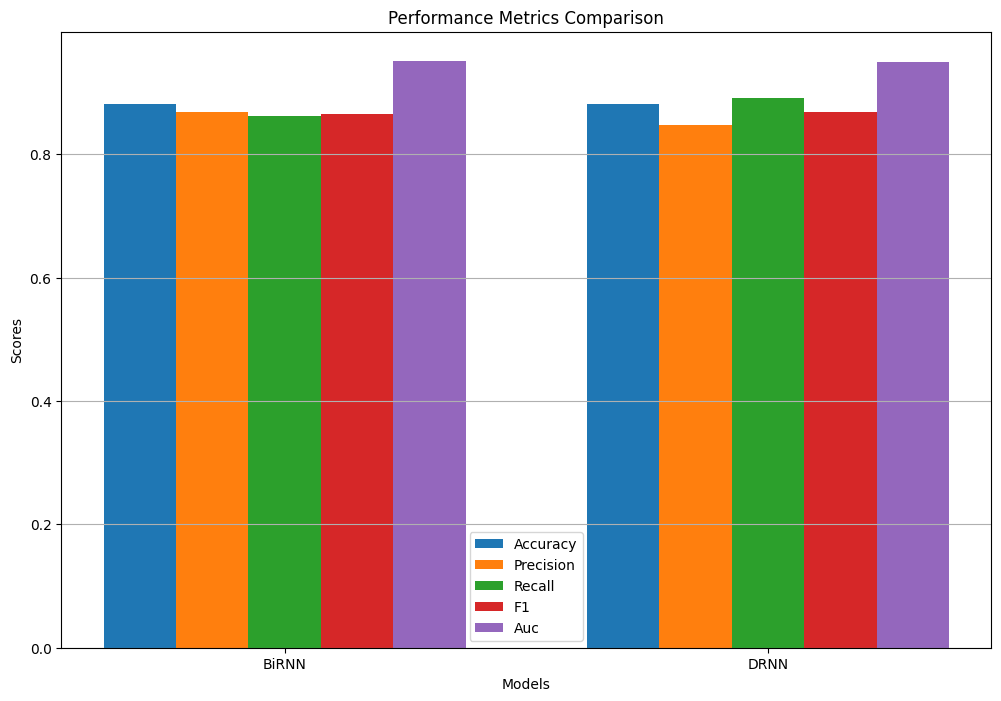

In [17]:
# Menghitung perbandingan untuk semua model
results_dict = {
    'BiRNN': result_birnn,
    'DRNN': result_drnn,
}

# Plotting ROC curve
plot_roc_curve(results_dict)
# Plotting perbandingan metrik
plot_metrics_comparison(results_dict)